**Including the Data set from the Internet to the tmp Folder**

In [38]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-06-08 20:22:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   128MB/s    in 1.1s    

2020-06-08 20:22:42 (128 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



**Unzip the Data Sets**

In [0]:
import os
import zipfile

local_zip='/tmp/horse-or-human.zip'
zip_ref=zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

**To read images from subdirectories, and automatically label them from the name of that subdirectory**

In [0]:
# Directory with our training horse pictures
train_horse_dir=os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir=os.path.join('/tmp/horse-or-human/humans')

**Print the Training Directory Data**

In [41]:
train_horse_names=os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names=os.listdir(train_human_dir)
print(train_human_names[:10])

['horse30-2.png', 'horse23-4.png', 'horse45-3.png', 'horse16-5.png', 'horse24-9.png', 'horse08-1.png', 'horse18-8.png', 'horse27-5.png', 'horse26-2.png', 'horse19-3.png']
['human09-04.png', 'human16-04.png', 'human04-17.png', 'human08-09.png', 'human13-15.png', 'human11-18.png', 'human08-30.png', 'human06-05.png', 'human06-16.png', 'human07-24.png']


**Findout Total No of Horse and Human Images**

In [42]:
print('total training horse images',len(train_horse_names))
print('total training human images',len(train_human_names))

total training horse images 500
total training human images 527


**Visualize the Images**

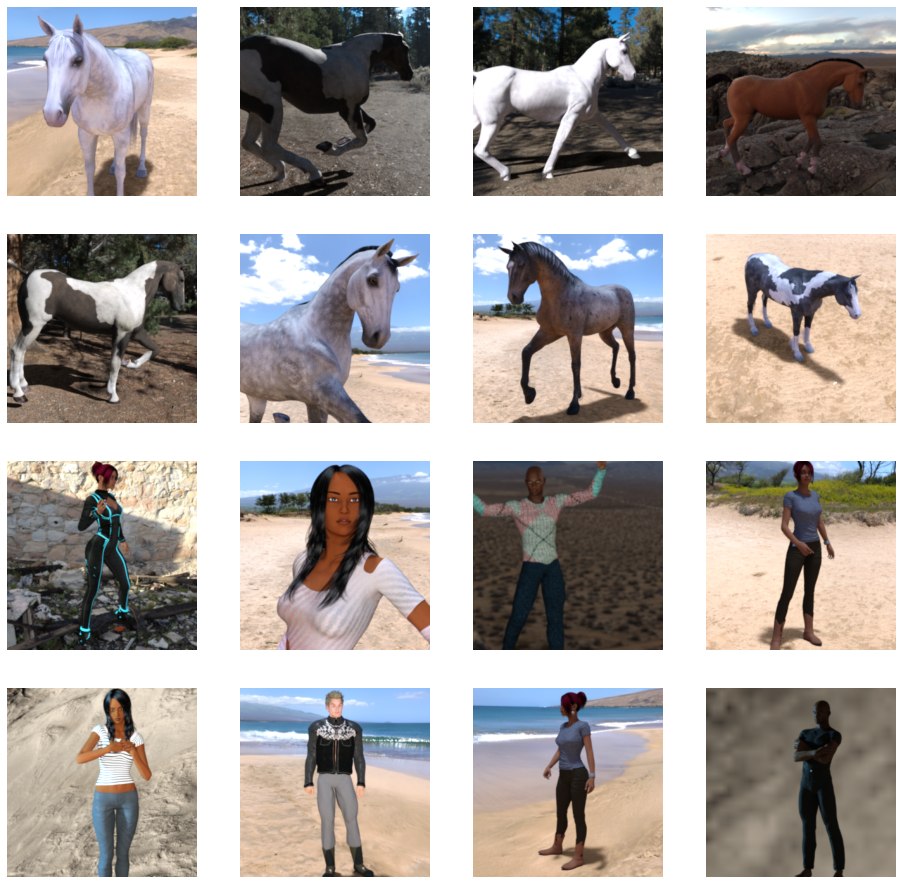

In [43]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Output the images in 4 X 4 configuration
nrows=4
ncols=4

# index for iterating over images
pic_index=0

# Set up matplotlib fig, and size it to fit 4X4 pics
fig=plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8;

next_horse_pix=[os.path.join(train_horse_dir, fname) for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix=[os.path.join(train_human_dir, fname) for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # set up subplot starting index at 1
  sp=plt.subplot(nrows, ncols, i+1)
  sp.axis('off')

  img=mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

**Model Building using Tensor Flow**

In [44]:
# step 1: import tensor flow
import tensorflow as tf

# step 2: create densely connected layers
model=tf.keras.models.Sequential([
                                  # the input shape is the desired size of the image 300x300 with 3 bytes color
                                  # the first convolution layer
                                  tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(300,300,3)),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  # the second convolution layer
                                  tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  # the third convolution layer
                                  tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  # the fourth convolution layer
                                  tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  # the fifth convolution layer
                                  tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  # flatten the layer to feed into the DNN
                                  tf.keras.layers.Flatten(),
                                  # 512 neurons hidden layers
                                  tf.keras.layers.Dense(512, activation='relu'),
                                  # only the one output layer that will be a value from 0-1 where 0 is for 'horses' and 1 is for 'humans'
                                  tf.keras.layers.Dense(1, activation='sigmoid')
])

# step 3: Create a model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 64)       

**Compile the Model**

In [0]:
# Step - 4: compile the model

# import the desired library
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

**Data Preprocessing**

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Images go into the neural networks be normalized to make it amenable for processing by the network
train_datagen=ImageDataGenerator(rescale=1/255)

# Flow the training images as a batch 
train_generator=train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # the source directory for training the images
         target_size=(300,300),  # All the images will be resized
         batch_size=128,
         class_mode='binary'     # binary_crossentropy is used as loss
         )

Found 1027 images belonging to 2 classes.
